In [2]:
import os
import random
import numpy as np

import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

from change_color_image import bgr_to_white_black_color
from generate_dataset import (
    add_square,
    add_rectangle,
    add_circle,
    add_parallelogram
)
from plot_image_with_label import (
    generate_collect_name,
    image_with_label
)
from train_val_test_split import generate_train_val_test
from batch import batch_split
from load_yolov_model import load_model

%matplotlib inline

In [3]:
PATH_TRAIN = 'data/train.csv'
PATH_TEST = 'data/test.csv'
IMG_PATH = 'img_path'
TARGET = 'label'
TYPE = 'type'
RANDOM_STATE = 42

In [4]:
df_train = pd.read_csv(PATH_TRAIN, sep=',')
df_test = pd.read_csv(PATH_TEST, sep=',')

In [5]:
df_train.shape, df_test.shape

((3000, 3), (6000, 1))

In [6]:
df_train.head()

,img_path,label,type
0,train_data/1.png,3,1
1,train_data/2.png,7,3
2,train_data/3.png,9,2
3,train_data/4.png,9,1
4,train_data/5.png,10,1


In [7]:
df_test.head()

,img_path
0,test_data/1.png
1,test_data/2.png
2,test_data/3.png
3,test_data/4.png
4,test_data/5.png


In [8]:
for df, name in zip([df_train, df_test], ['train', 'test']):
    set_shape = set()
    for img_path in tqdm(df[IMG_PATH]):
        im = cv2.imread(f'data/{img_path}')
        set_shape.add(im.shape)

    print(f'{name}: {set_shape}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1273.31it/s]


train: {(320, 320, 3)}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1256.44it/s]

test: {(320, 320, 3)}


Number of square: 1


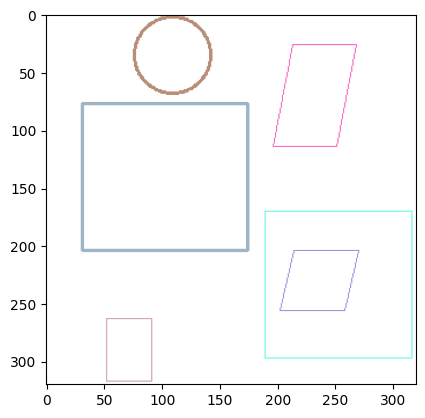

In [9]:
# It can be assumed that this is a synthetic data

example_index = 2452

print(f'Number of square: {df_train[TARGET][example_index]}')

image = cv2.imread(f'data/train_data/{example_index + 1}.png')

plt.imshow(image)

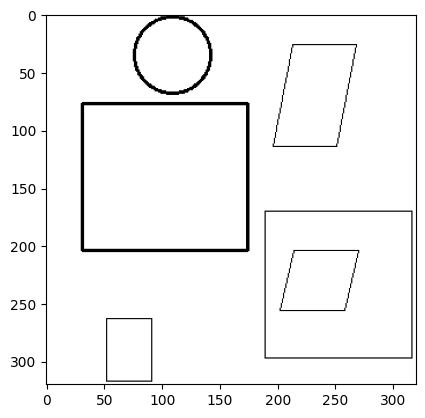

In [10]:
image_wb = bgr_to_white_black_color(image)

plt.imshow(image_wb)

### classification -> detection (COCO format)

In [11]:
RANDOM_STATE = 42
HEIGHT, WIDTH, CHANNEL = 320, 320, 3
COLOR_WHITE = 255
COLOR_BGR = (0, 0, 0)
CLASS_SQUARE = 0

N = 20_000
PATH_DATASET = r'synthetic_coco_data/dataset'

random.seed(RANDOM_STATE)

In [12]:
for i in tqdm(range(N)):
    image = np.full((HEIGHT, WIDTH, CHANNEL), COLOR_WHITE, dtype="uint8")

    n_square = random.randint(0, 8)
    n_rectangle = random.randint(0, min(6, n_square))
    n_circle = random.randint(0, min(4, n_rectangle))
    n_parallelogram = random.randint(0, min(3, n_circle))

    image, coco_label = add_square(image, n_square, HEIGHT, WIDTH, COLOR_BGR)
    image = add_rectangle(image, n_rectangle, HEIGHT, WIDTH, COLOR_BGR)
    image = add_circle(image, n_circle, HEIGHT, WIDTH, COLOR_BGR)
    image = add_parallelogram(image, n_parallelogram, HEIGHT, WIDTH, COLOR_BGR)

    cv2.imwrite(os.path.join(PATH_DATASET, f'images/{i}.png'), image)

    with open(os.path.join(PATH_DATASET, f'labels/{i}.txt'), 'w') as fio:
        coco_label = [f'{CLASS_SQUARE} ' + ' '.join(map(str, label)) for label in coco_label]
        coco_label = '\n'.join(coco_label)
        fio.write(coco_label)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 717.29it/s]


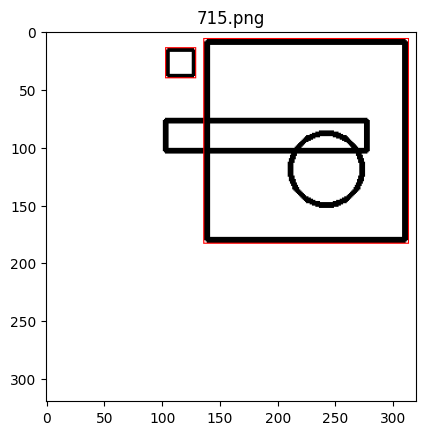

In [13]:
collect_name = generate_collect_name(PATH_DATASET, count=1)

for name in collect_name:
    path_image = fr'{PATH_DATASET}/images/{name}.png'
    path_label = fr'{PATH_DATASET}/labels/{name}.txt'

    if not os.path.isfile(path_label):
        print(f'Not found: {path_label}')
        continue

    filename, image = image_with_label(path_picture=path_image, path_label=path_label)

    plt.title(filename)
    plt.imshow(image)

In [14]:
PATH_FROM = r'synthetic_coco_data/dataset'
PATH_TO = r'synthetic_coco_data/train_val_test'

In [15]:
generate_train_val_test(PATH_FROM, PATH_TO, RANDOM_STATE)

Directory created: synthetic_coco_data/train_val_test/train/images
Directory created: synthetic_coco_data/train_val_test/train/labels
Directory created: synthetic_coco_data/train_val_test/val/images
Directory created: synthetic_coco_data/train_val_test/val/labels
Directory created: synthetic_coco_data/train_val_test/test/images
Directory created: synthetic_coco_data/train_val_test/test/labels
Train done
Val done
Test done


### fit yolov model and save model

For example:

    git clone https://github.com/ultralytics/yolov5

    add train/val/test data, yaml-file for training

    make venv, install requirements

    and do:
    CUDA_VISIBLE_DEVICES=0 python train.py --data data/train_val_test.yaml --name square --epochs 50 --weights yolov5l.pt --hyp data/hyps/hyp.scratch-med.yaml --imgsz 320 --batch 64

    P.s. you can see example train_val_test.yaml here: machine_learning_exam/ml_2/model/square_v3/train_val_test.yaml

In [16]:
PATH_YOLOV_MODEL = 'model/square_v3/best.pt'
DEFAULT_DIR_YOLOV_REPO = r'ultralytics_yolov5_master_min'

In [17]:
model = load_model(DEFAULT_DIR_YOLOV_REPO, PATH_YOLOV_MODEL)

YOLOv5  2022-6-1 torch 1.12.1+cpu CPU

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients
Adding AutoShape... 


Before:
0.25
0.45

After:
0.25
0.45


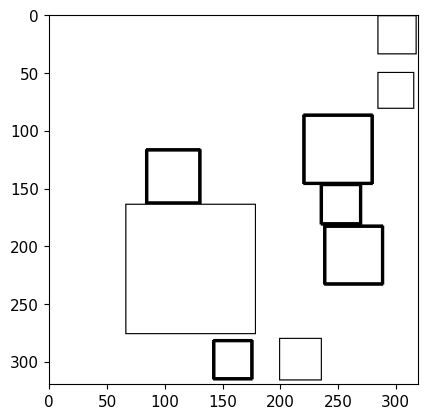

In [20]:
example_train_index = 4

example_image = cv2.imread(f'data/train_data/{example_train_index}.png')
example_image = bgr_to_white_black_color(example_image)

result = model(example_image)

plt.imshow(example_image)

Found 9 from 9 images


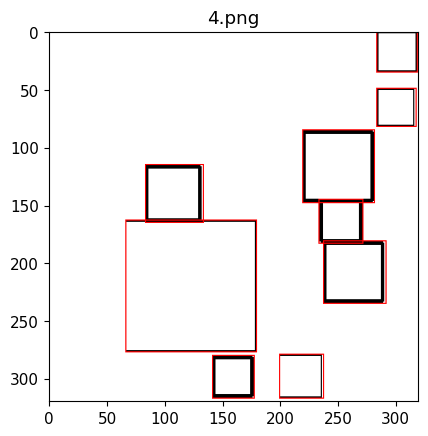

In [21]:
df_detect = result.pandas().xyxy[0]

thickness = 1
color = (255, 0, 0)
for idx in df_detect.index:
    x0, y0 = df_detect['xmin'][idx], df_detect['ymin'][idx]
    x1, y1 = df_detect['xmax'][idx], df_detect['ymax'][idx]
    
    x0, y0 = round(x0), round(y0)
    x1, y1 = round(x1), round(y1)
    
    example_image = cv2.rectangle(example_image, (x0, y0), (x1, y1), color, thickness=thickness)
    
print(f'Found {df_detect.shape[0]} from {df_train["label"][example_train_index - 1]} images')

plt.title(f'{example_train_index}.png')
plt.imshow(example_image)

In [22]:
# better with GPU

model = load_model(DEFAULT_DIR_YOLOV_REPO, PATH_YOLOV_MODEL)

images = df_train[IMG_PATH].tolist()
collect_predict = []

for batch in tqdm(batch_split(images, 10)):
    batch_img = [cv2.imread(f'data/{path}') for path in batch]
    batch_img = [bgr_to_white_black_color(img) for img in batch_img]

    predict = model(batch_img)
    predict_pandas = predict.pandas()
    predict_n_square = [df.shape[0] for df in predict_pandas.xyxy]

    collect_predict += predict_n_square

print('rmse:', mean_squared_error(df_train['label'], collect_predict, squared=False))
print('mae:', mean_absolute_error(df_train['label'], collect_predict))

YOLOv5  2022-6-1 torch 1.12.1+cpu CPU

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients
Adding AutoShape... 


Before:
0.25
0.45

After:
0.25
0.45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [39:35<00:00,  7.92s/it]

rmse: 0.5882176467941097
mae: 0.2906666666666667


In [23]:
model = load_model(DEFAULT_DIR_YOLOV_REPO, PATH_YOLOV_MODEL, iou=0.7)

images = df_train[IMG_PATH].tolist()
collect_predict = []

for batch in tqdm(batch_split(images, 10)):
    batch_img = [cv2.imread(f'data/{path}') for path in batch]
    batch_img = [bgr_to_white_black_color(img) for img in batch_img]

    predict = model(batch_img)
    predict_pandas = predict.pandas()
    predict_n_square = [df.shape[0] for df in predict_pandas.xyxy]

    collect_predict += predict_n_square

print('rmse:', mean_squared_error(df_train['label'], collect_predict, squared=False))
print('mae:', mean_absolute_error(df_train['label'], collect_predict))

YOLOv5  2022-6-1 torch 1.12.1+cpu CPU

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients
Adding AutoShape... 


Before:
0.25
0.45

After:
0.25
0.7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [39:20<00:00,  7.87s/it]

rmse: 0.5029910535983717
mae: 0.217


### Data leakage (for fun)

In [24]:
for df in [df_train, df_test]:
    collect_kbyte = []
    for img_path in tqdm(df[IMG_PATH]):
        file_stats = os.stat(f'data/{img_path}')
        collect_kbyte.append(file_stats.st_size / 1024)

    df['kbyte'] = collect_kbyte

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 37267.35it/s]


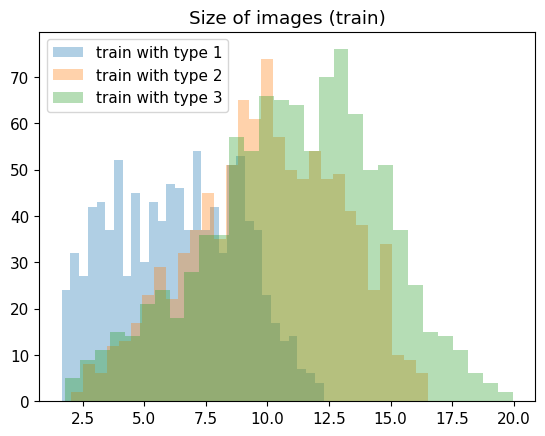

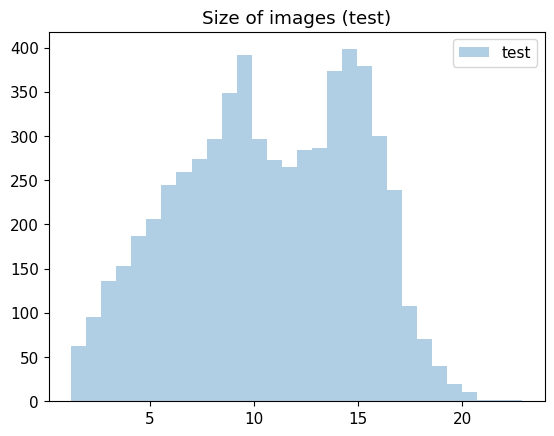

In [25]:
for type_i in range(1, 4):
    label_i = df_train[df_train['type'] == type_i]['kbyte']
    plt.hist(label_i, bins=30, alpha=0.35, label=f'train with type {type_i}')
plt.title('Size of images (train)')
plt.legend()
plt.show()

plt.hist(df_test['kbyte'], bins=30, alpha=0.35, label='test')
plt.title('Size of images (test)')
plt.legend()
plt.show()

Sort by last modified time gives an excellent split by image type: 1, 2, 3 

(see df_train["type"])